
# Pipeline de Feature Engineering para Predicción de Arribos de Bicicletas

## Objetivo
Transformar datos de recorridos en features para predecir arribos en intervalos de 30 minutos.

### Datos de Entrada:
- `id_recorrido`, `duracion_recorrido`, `id_estacion_origen`, `nombre_estacion_origen`, etc.

### Datos de Salida:
- Features engineered para ML: clusters geográficos, ventanas temporales, features históricas (prev_n)
- Variable objetivo: `N_arribos_intervalo`

### Sin Data Leakage
Para predecir arribos en [T, T+30] solo usa información conocida antes de T.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('src')

import pandas as pd
import numpy as np
from src.feature_engineering import BikeFeatureEngineering

# Configuración
INPUT_FILE = '../data/processed/trips_enriched.csv'
OUTPUT_FILE = '../data/processed/trips_final_features.csv'


In [3]:
# Verificar datos de entrada
if os.path.exists(INPUT_FILE):
    print("✅ Archivo de entrada encontrado")
    
    # Leer solo el header para verificar columnas
    df_sample = pd.read_csv(INPUT_FILE, nrows=1)
    print(f"Columnas de entrada: {len(df_sample.columns)}")
    print("Primeras columnas:", list(df_sample.columns[:10]))
else:
    print("❌ Archivo de entrada no encontrado")


✅ Archivo de entrada encontrado
Columnas de entrada: 20
Primeras columnas: ['id_recorrido', 'duracion_recorrido', 'id_estacion_origen', 'nombre_estacion_origen', 'direccion_estacion_origen', 'long_estacion_origen', 'lat_estacion_origen', 'id_estacion_destino', 'nombre_estacion_destino', 'direccion_estacion_destino']


In [4]:
# Ejecutar pipeline de feature engineering
print("🚀 Iniciando feature engineering...")

fe = BikeFeatureEngineering(
    time_window_minutes=30,  # Intervalos de 30 minutos
    n_clusters=16           # 16 clusters geográficos
)

# NOTA: Esto puede tomar varios minutos con el dataset completo
# Para pruebas rápidas, considera usar una muestra más pequeña


🚀 Iniciando feature engineering...


In [5]:
# Para testear con muestra pequeña (opcional)
USE_SAMPLE = False  # Cambiar a False para dataset completo

if USE_SAMPLE:
    print("⚡ Usando muestra pequeña para testing")
    # Crear muestra de 10,000 filas para pruebas rápidas
    df_full = pd.read_csv(INPUT_FILE, nrows=15000000)
    sample_file = '../data/processed/trips_sample.csv'
    df_full.to_csv(sample_file, index=False)
    
    # Procesar muestra
    df_processed = fe.transform(sample_file, sample_file.replace('.csv', '_features.csv'))
else:
    # Procesar dataset completo
    df_processed = fe.transform(INPUT_FILE, OUTPUT_FILE)


=== INICIANDO FEATURE ENGINEERING ===
Cargando dataset...
Dataset cargado: (12785807, 20)
Creando ventanas temporales...
Creando clusters geográficos...
Creando features básicas...
Calculando conteos por intervalo...
Creando features históricas...
Seleccionando features finales...
Guardando dataset transformado: ../data/processed/trips_final_features.csv
=== FEATURE ENGINEERING COMPLETADO ===
Dataset final: (12785807, 77)
Columnas: 77


In [6]:
# Verificar resultados
print("📊 Resultados del feature engineering:")
print(f"Shape final: {df_processed.shape}")
print(f"Columnas generadas: {len(df_processed.columns)}")
print("\nPrimeras columnas:", list(df_processed.columns[:10]))
print("\nÚltimas columnas:", list(df_processed.columns[-10:]))

# Verificar variable objetivo
print(f"\nVariable objetivo N_arribos_intervalo:")
print(f"  - Valores únicos: {df_processed['N_arribos_intervalo'].nunique()}")
print(f"  - Rango: {df_processed['N_arribos_intervalo'].min()} - {df_processed['N_arribos_intervalo'].max()}")
print(f"  - Media: {df_processed['N_arribos_intervalo'].mean():.2f}")
print(f"  - Nulls: {df_processed['N_arribos_intervalo'].isna().sum()}")


📊 Resultados del feature engineering:
Shape final: (12785807, 77)
Columnas generadas: 77

Primeras columnas: ['id_recorrido', 'duracion_recorrido', 'id_estacion_origen', 'id_estacion_destino', 'id_usuario', 'modelo_bicicleta', 'dia_semana', 'es_finde', 'estacion_del_año', 'edad_usuario']

Últimas columnas: ['N_ARRIBOS_prev_2', 'N_SALIDAS_prev_2', 'N_ARRIBOS_prev_3', 'N_SALIDAS_prev_3', 'N_ARRIBOS_prev_4', 'N_SALIDAS_prev_4', 'N_ARRIBOS_prev_5', 'N_SALIDAS_prev_5', 'N_ARRIBOS_prev_6', 'N_SALIDAS_prev_6']

Variable objetivo N_arribos_intervalo:
  - Valores únicos: 36
  - Rango: 0.0 - 36.0
  - Media: 2.75
  - Nulls: 0


# Entrenamiento XGBoost con Loss de Poisson

## Características del modelo:
- **Loss Function**: Poisson (ideal para conteos)
- **Split**: Temporal (no random, evita data leakage)
- **Features**: Solo información disponible antes de T
- **Objetivo**: Predecir `N_arribos_intervalo`


In [7]:
# Entrenar modelo XGBoost
from src.train_model import BikeXGBoostTrainer

# Verificar que tenemos datos procesados
if 'df_processed' in locals():
    print("✅ Usando datos ya procesados")
    df_model = df_processed
else:
    print("📁 Cargando datos procesados...")
    df_model = pd.read_csv(OUTPUT_FILE if USE_SAMPLE else OUTPUT_FILE)

print(f"Dataset para modelo: {df_model.shape}")
print(f"Variable objetivo stats: min={df_model['N_arribos_intervalo'].min()}, max={df_model['N_arribos_intervalo'].max()}")


✅ Usando datos ya procesados
Dataset para modelo: (12785807, 77)
Variable objetivo stats: min=0.0, max=36.0


In [8]:
# Crear y configurar entrenador
trainer = BikeXGBoostTrainer(poisson_max_delta_step=0.7)

# Verificar features que se van a usar (sin information leakage)
sample_features = trainer.identify_valid_features(df_model)
print(f"\n🔒 Features válidas (sin data leakage): {len(sample_features)}")
print("Algunos ejemplos:", sample_features[:10])

# Verificar features excluidas
excluded = ['año_destino', 'mes_destino', 'dia_destino', 'hora_destino', 'fecha_intervalo', 'N_salidas_intervalo']
for col in excluded:
    if col in df_model.columns:
        print(f"❌ {col} - EXCLUIDA (información del futuro)")
    else:
        print(f"⚠️  {col} - No encontrada")


Features válidas identificadas: 63
Features del futuro excluidas: 14

🔒 Features válidas (sin data leakage): 63
Algunos ejemplos: ['id_recorrido', 'duracion_recorrido', 'id_estacion_origen', 'id_estacion_destino', 'id_usuario', 'modelo_bicicleta', 'estacion_referencia', 'año_origen', 'mes_origen', 'dia_origen']
❌ año_destino - EXCLUIDA (información del futuro)
❌ mes_destino - EXCLUIDA (información del futuro)
❌ dia_destino - EXCLUIDA (información del futuro)
❌ hora_destino - EXCLUIDA (información del futuro)
❌ fecha_intervalo - EXCLUIDA (información del futuro)
❌ N_salidas_intervalo - EXCLUIDA (información del futuro)


In [9]:
# Configurar parámetros del modelo XGBoost con Poisson
model_params = {
    'objective': 'count:poisson',      # Loss de Poisson para conteos
    'eval_metric': 'poisson-nloglik',  # Métrica de evaluación
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'max_delta_step': 0.7,  # Importante para Poisson
    'tree_method': 'gpu_hist'  # Usar GPU para entrenamiento
}

print("🎯 Parámetros configurados para XGBoost con Poisson")
print("   Objetivo: Predecir conteos de arribos")
print("   Split: Temporal (evita data leakage)")
print("   Features: Solo información histórica")


🎯 Parámetros configurados para XGBoost con Poisson
   Objetivo: Predecir conteos de arribos
   Split: Temporal (evita data leakage)
   Features: Solo información histórica


In [10]:
# ENTRENAR MODELO
# NOTA: Esto puede tomar varios minutos dependiendo del tamaño del dataset

print("🚀 Iniciando entrenamiento...")
print("⏰ Esto puede tomar unos minutos...")

try:
    # Entrenar con split temporal automático
    results, test_data = trainer.train(df_model, model_params)
    
    print("✅ Entrenamiento completado!")
    print(f"📊 Resultados finales:")
    print(f"   - Test RMSE: {results['test_rmse']:.4f}")
    print(f"   - Test MAE:  {results['test_mae']:.4f}")
    print(f"   - Test R2:  {results['test_r2']:.4f}")
    print(f"   - Features:  {results['n_features']}")
    
except Exception as e:
    print(f"❌ Error durante entrenamiento: {str(e)}")
    # Para debugging
    import traceback
    traceback.print_exc()


🚀 Iniciando entrenamiento...
⏰ Esto puede tomar unos minutos...
=== INICIANDO ENTRENAMIENTO XGBOOST ===
Split temporal realizado:
  Train: 8,950,064 filas (70.0%)
  Val:   1,917,871 filas (15.0%)
  Test:  1,917,872 filas (15.0%)
  Fechas train: 2020-01-01 00:00:00 a 2023-04-05 13:00:00
  Fechas test:  2024-01-06 22:30:00 a 2024-09-14 16:30:00
Features válidas identificadas: 63
Features del futuro excluidas: 14
Datos preparados: 8950064 filas, 63 features
Target stats: min=0.0, max=36.0, mean=2.84
Features válidas identificadas: 63
Features del futuro excluidas: 14
Datos preparados: 1917871 filas, 63 features
Target stats: min=0.0, max=21.0, mean=2.47
Features válidas identificadas: 63
Features del futuro excluidas: 14
Datos preparados: 1917872 filas, 63 features
Target stats: min=1.0, max=26.0, mean=2.60
Entrenando XGBoost...
[0]	train-poisson-nloglik:3.73063	eval-poisson-nloglik:3.20612
[100]	train-poisson-nloglik:1.51856	eval-poisson-nloglik:1.44912
[200]	train-poisson-nloglik:1.5146

Traceback (most recent call last):
  File "C:\Users\Matteo\AppData\Local\Temp\ipykernel_10960\4151138894.py", line 15, in <module>
    print(f"   - Test R2:  {results['test_r2']:.4f}")
KeyError: 'test_r2'



=== FEATURE IMPORTANCE ===
✅ Top 20 features más importantes graficadas


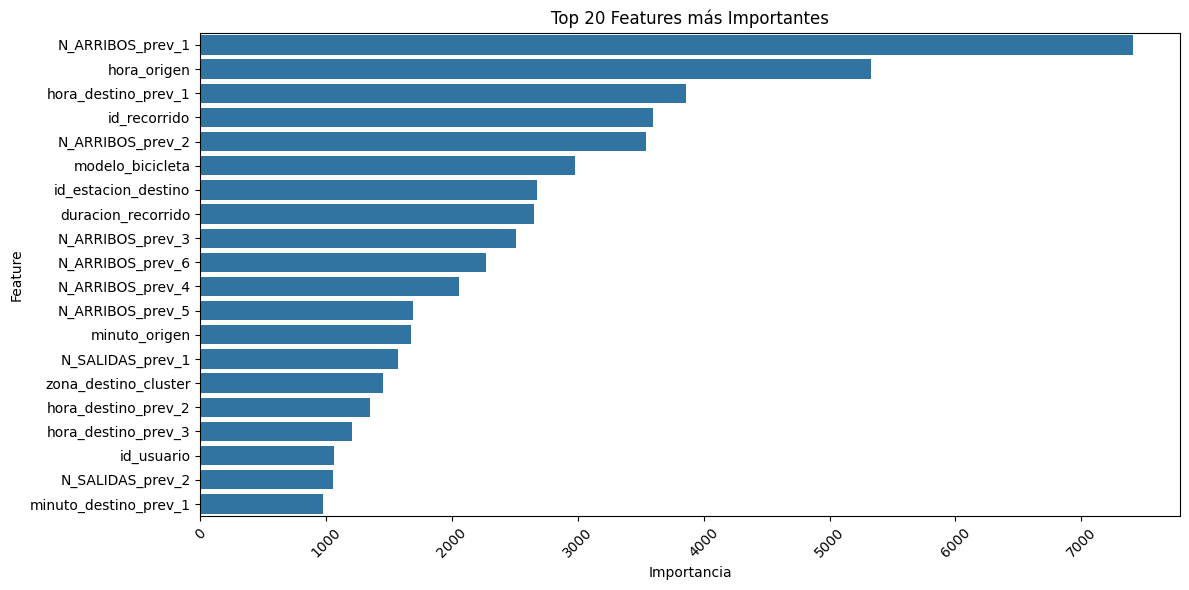

In [11]:
# Graficar feature importance
print("\n=== FEATURE IMPORTANCE ===")

# Obtener importancia de features
importance = trainer.model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Convertir a DataFrame para graficar
import matplotlib.pyplot as plt
import seaborn as sns

df_importance = pd.DataFrame(sorted_importance[:20], columns=['Feature', 'Importance'])

# Crear gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_importance, x='Importance', y='Feature')
plt.title('Top 20 Features más Importantes')
plt.xlabel('Importancia')
plt.ylabel('Feature')

# Rotar labels para mejor visualización
plt.xticks(rotation=45)
plt.tight_layout()

print("✅ Top 20 features más importantes graficadas")
